### Imports, initialization of constants, general set up

In [1]:
import os
import matplotlib.pylab as plt
import pandas as pd
import numpy as np


DATASETS = ["cacm", "med", "npl"]


### Plotting functions

In [38]:
def scatter_plot(result_file_names, axis_descriptions, title, fig_filename=""):
    figure, axis = plt.subplots(1, 3, figsize=(14, 5))
    for i, dataset in enumerate(DATASETS):
        # load results from trec_eval format
        x = pd.read_csv(result_file_names[0] % dataset, sep="\t", header=None).sort_values(by=[1])[2].to_numpy()
        y = pd.read_csv(result_file_names[1] % dataset, sep="\t", header=None).sort_values(by=[1])[2].to_numpy()

        # plot the results nicely
        axis[i].set_aspect(1)
        axis[i].scatter(x[:-1], y[:-1], c="m", label="Score for each query")
        axis[i].scatter(x[-1], y[-1], s=[200], c="c", label="Average score")
        axis[i].plot(np.linspace(-0.025, 1.025), np.linspace(-0.025, 1.025), label="Identity line", c="orange", alpha=0.75)
        axis[i].set_xlim(-0.025, 1.025)
        axis[i].set_ylim(-0.025, 1.025)
        axis[i].set_xlabel(axis_descriptions[0])
        axis[i].set_ylabel(axis_descriptions[1])
        axis[i].set_title(f"{dataset} dataset")
        axis[i].legend()
    
    # remove unnecessary white space on the plot
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.91)
    figure.suptitle(title, fontsize=16)

    # save the plot if a file is specified
    if fig_filename:
        plt.savefig(fig_filename, dpi=300)
    plt.show()


def bar_chart_plot(x_input_template, y_input_template, legend_names, barchart_name, fig_filename=""):
    # Create an empty list to store the data frames
    df_list_one = []
    df_list_two = []

    # Iterate over the input files
    for dataset in DATASETS:
        # Read the file into a data frame
        df = pd.read_csv(x_input_template % dataset, sep='\t', names=['map', 'index', 'value'])

        # Extract the rows with the 'all' index
        df_all = df[df['index'] == 'all']
        value = df_all['value'].iloc[0]
        # Add the data frame to the list
        df_list_one.append(value)

        # Read the file into a data frame
        df = pd.read_csv(y_input_template % dataset, sep='\t', names=['map', 'index', 'value'])

        # Extract the rows with the 'all' index
        df_all = df[df['index'] == 'all']
        value = df_all['value'].iloc[0]
        # Add the data frame to the list
        df_list_two.append(value)


    # Create a data frame with the values and names
    df = pd.DataFrame({'values_one': df_list_one, 'values_two': df_list_two, 'names': DATASETS})

    # Set the bar width
    bar_width = 0.4

    # Calculate the x-coordinates for the bars
    x = range(len(df))

    # Create the plot
    fig, ax = plt.subplots()
    ax.bar(x, df['values_one'], width=bar_width, label=legend_names[0], color='m')
    ax.bar([i + bar_width for i in x], df['values_two'], width=bar_width, label=legend_names[1], color='c')
    ax.set_ylabel("Mean Average Precision")
    ax.set_title(barchart_name)
    ax.set_xticks([i + bar_width / 2 for i in x], df['names'])
    ax.legend()

    if fig_filename:
        plt.savefig(fig_filename, dpi=300)
    plt.show()

def bar_chart_plot_4_in_1(x_input_templates, y_input_templates, legend_names, barchart_name, fig_filename=""):
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    for i, (x_input_template, y_input_template) in enumerate(zip(x_input_templates, y_input_templates)):
        # Create an empty list to store the data frames
        df_list_one = []
        df_list_two = []

        # Iterate over the input files
        for dataset in DATASETS:
            # Read the file into a data frame
            df = pd.read_csv(x_input_template % dataset, sep='\t', names=['map', 'index', 'value'])

            # Extract the rows with the 'all' index
            df_all = df[df['index'] == 'all']
            value = df_all['value'].iloc[0]
            # Add the data frame to the list
            df_list_one.append(value)

            # Read the file into a data frame
            df = pd.read_csv(y_input_template % dataset, sep='\t', names=['map', 'index', 'value'])

            # Extract the rows with the 'all' index
            df_all = df[df['index'] == 'all']
            value = df_all['value'].iloc[0]
            # Add the data frame to the list
            df_list_two.append(value)


        # Create a data frame with the values and names
        df = pd.DataFrame({'values_one': df_list_one, 'values_two': df_list_two, 'names': DATASETS})

        # Set the bar width
        bar_width = 0.4

        # Calculate the x-coordinates for the bars
        x = range(len(df))

        # Create the plot
        j = i // 2
        k = i & 1
        ax[j, k].bar(x, df['values_one'], width=bar_width, label=legend_names[i][0], color='m')
        ax[j, k].bar([i + bar_width for i in x], df['values_two'], width=bar_width, label=legend_names[i][1], color='c')
        ax[j, k].set_ylabel("Mean Average Precision")
        ax[j, k].set_xticks([i + bar_width / 2 for i in x], df['names'])
        ax[j, k].legend()

    fig.suptitle(barchart_name, fontsize=16)
    plt.subplots_adjust(left=0.055, bottom=0.03, right=0.985, top=0.95, hspace=0.08, wspace=0.15)

    if fig_filename:
        plt.savefig(fig_filename, dpi=300)
    plt.show()
    
    
def bar_chart_plot_nx_ny(x_input_templates, y_input_templates, legend_names, barchart_name, fig_filename="", nx=2, ny=2):
    
    fig, ax = plt.subplots(nx, ny, figsize=(12, 5*nx))
    ax = ax.flatten()

    for i, (x_input_template, y_input_template) in enumerate(zip(x_input_templates, y_input_templates)):
        # Create an empty list to store the data frames
        df_list_one = []
        df_list_two = []

        # Iterate over the input files
        for dataset in DATASETS:
            # Read the file into a data frame
            df = pd.read_csv(x_input_template % dataset, sep='\t', names=['map', 'index', 'value'])

            # Extract the rows with the 'all' index
            df_all = df[df['index'] == 'all']
            value = df_all['value'].iloc[0]
            # Add the data frame to the list
            df_list_one.append(value)

            # Read the file into a data frame
            df = pd.read_csv(y_input_template % dataset, sep='\t', names=['map', 'index', 'value'])

            # Extract the rows with the 'all' index
            df_all = df[df['index'] == 'all']
            value = df_all['value'].iloc[0]
            # Add the data frame to the list
            df_list_two.append(value)


        # Create a data frame with the values and names
        df = pd.DataFrame({'values_one': df_list_one, 'values_two': df_list_two, 'names': DATASETS})

        # Set the bar width
        bar_width = 0.4

        # Calculate the x-coordinates for the bars
        x = range(len(df))

        # Create the plot
        ax[i].bar(x, df['values_one'], width=bar_width, label=legend_names[i][0], color='m')
        ax[i].bar([i + bar_width for i in x], df['values_two'], width=bar_width, label=legend_names[i][1], color='c')
        ax[i].set_ylabel("Mean Average Precision")
        ax[i].set_xticks([i + bar_width / 2 for i in x], df['names'])
        ax[i].legend()

    fig.suptitle(barchart_name, fontsize=16)
    #plt.subplots_adjust(left=0.055, bottom=0.03, right=0.985, top=0.92, hspace=0.08, wspace=0.15)

    if fig_filename:
        plt.savefig(fig_filename, dpi=300)
    plt.show()

## Reference
We chose the BM-25 search as our reference fro all tasks.

## Task 01
In this task we compared BM-25 search with cosine similarity search using embeddings created by different sentence transformers.

In [6]:
!mkdir -p presentation/figures

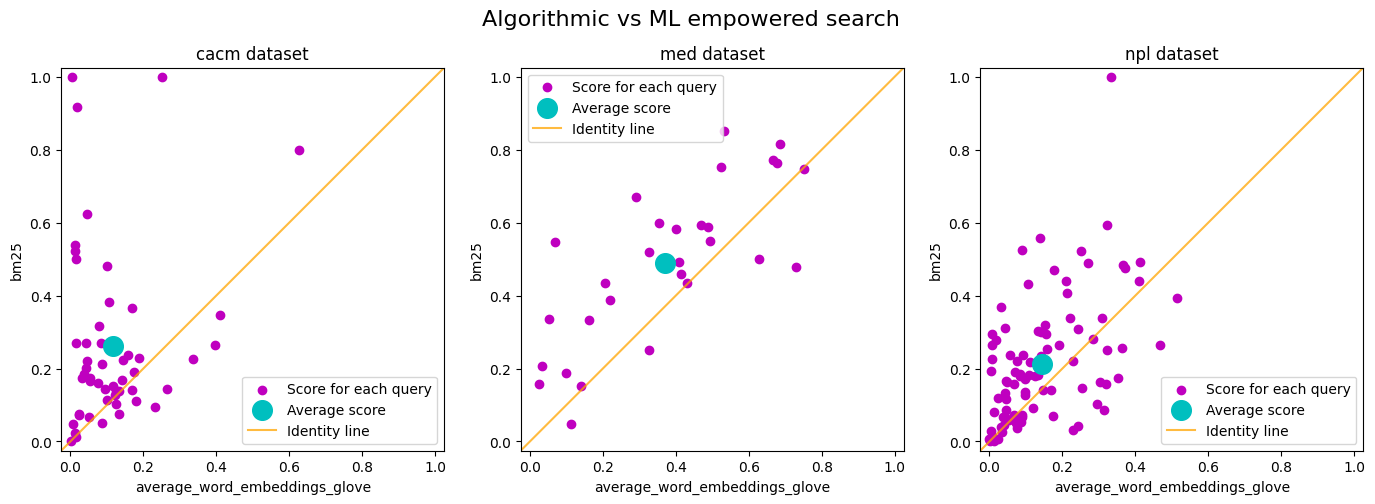

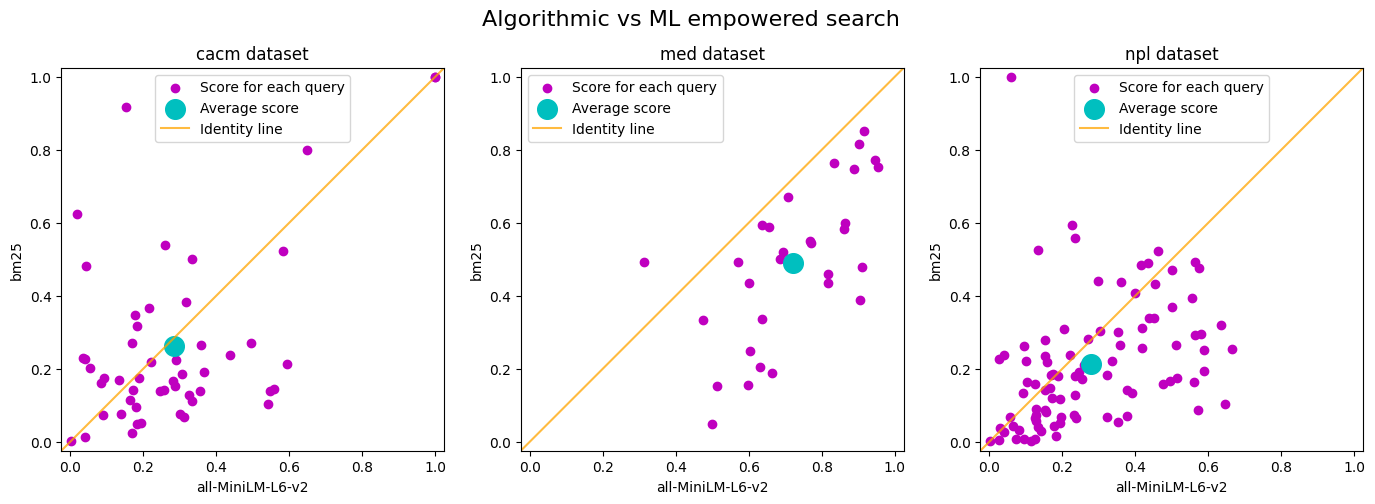

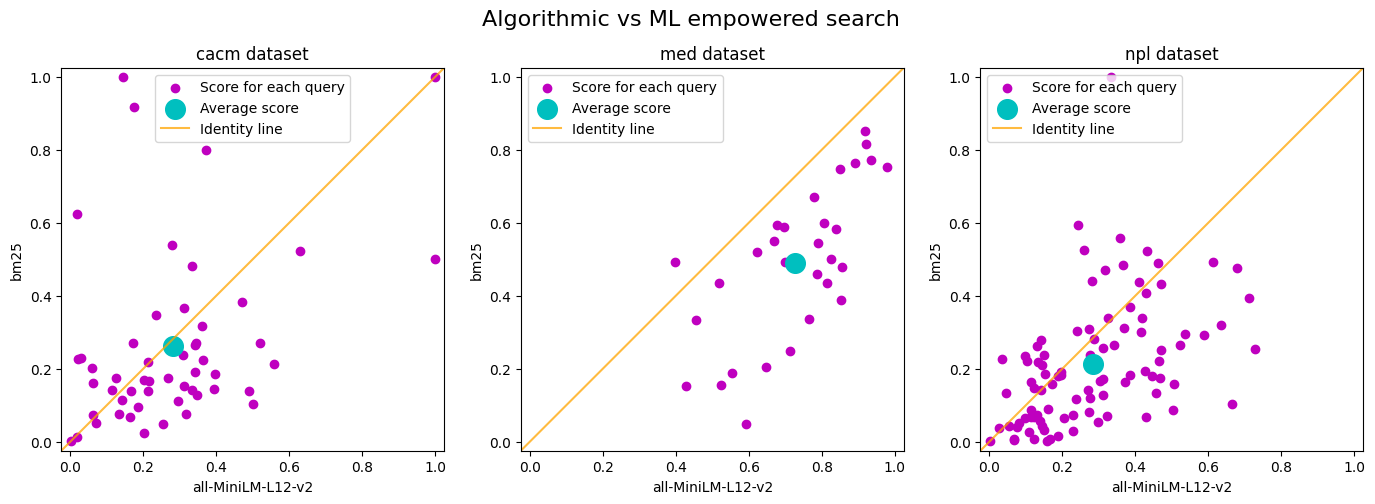

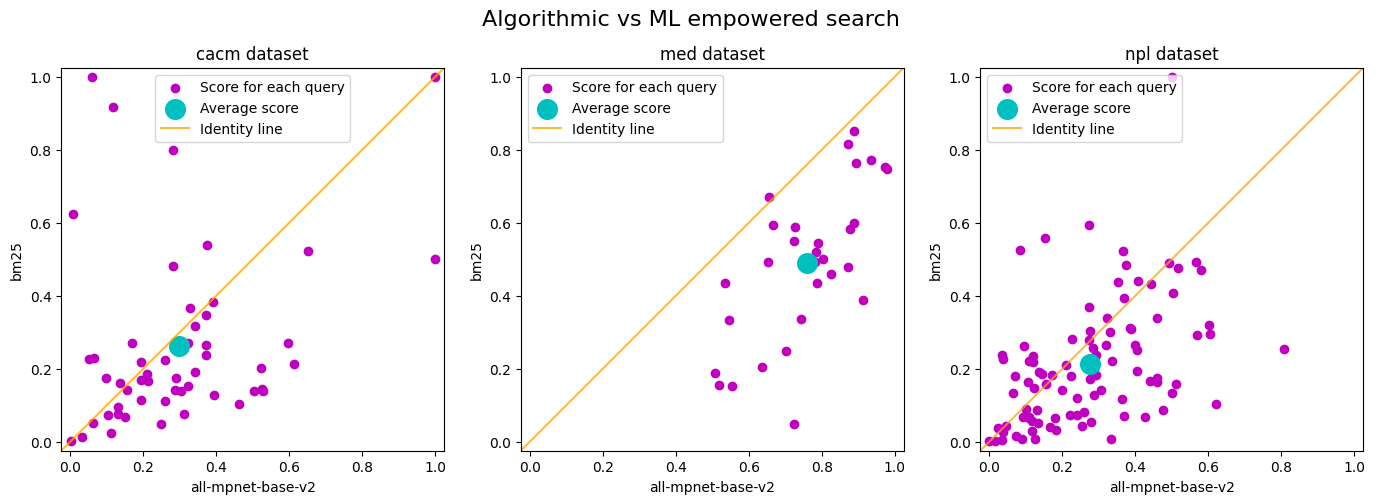

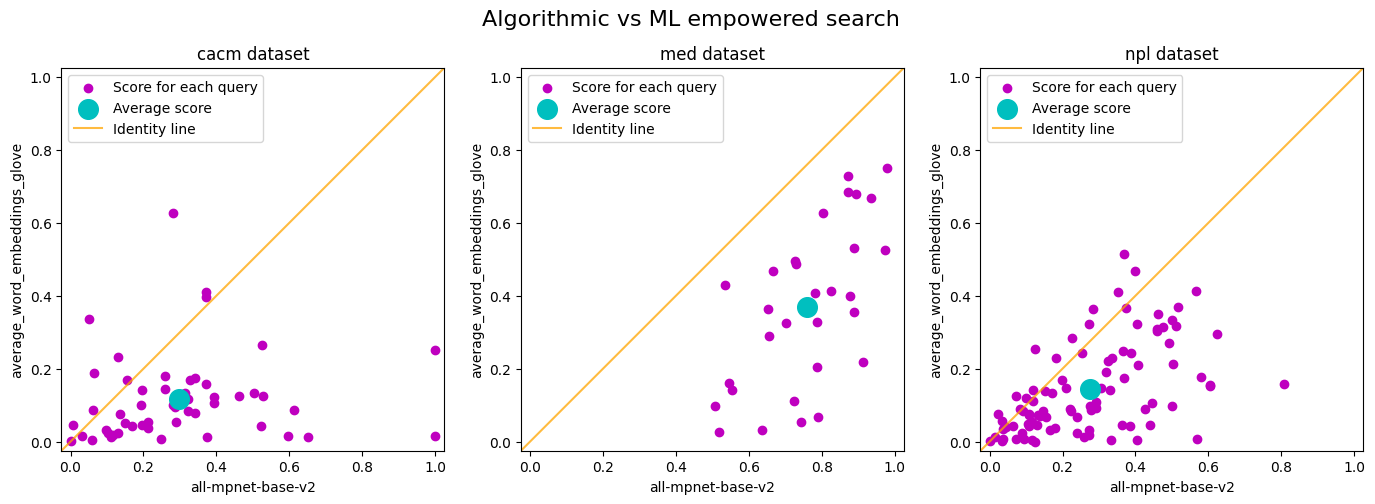

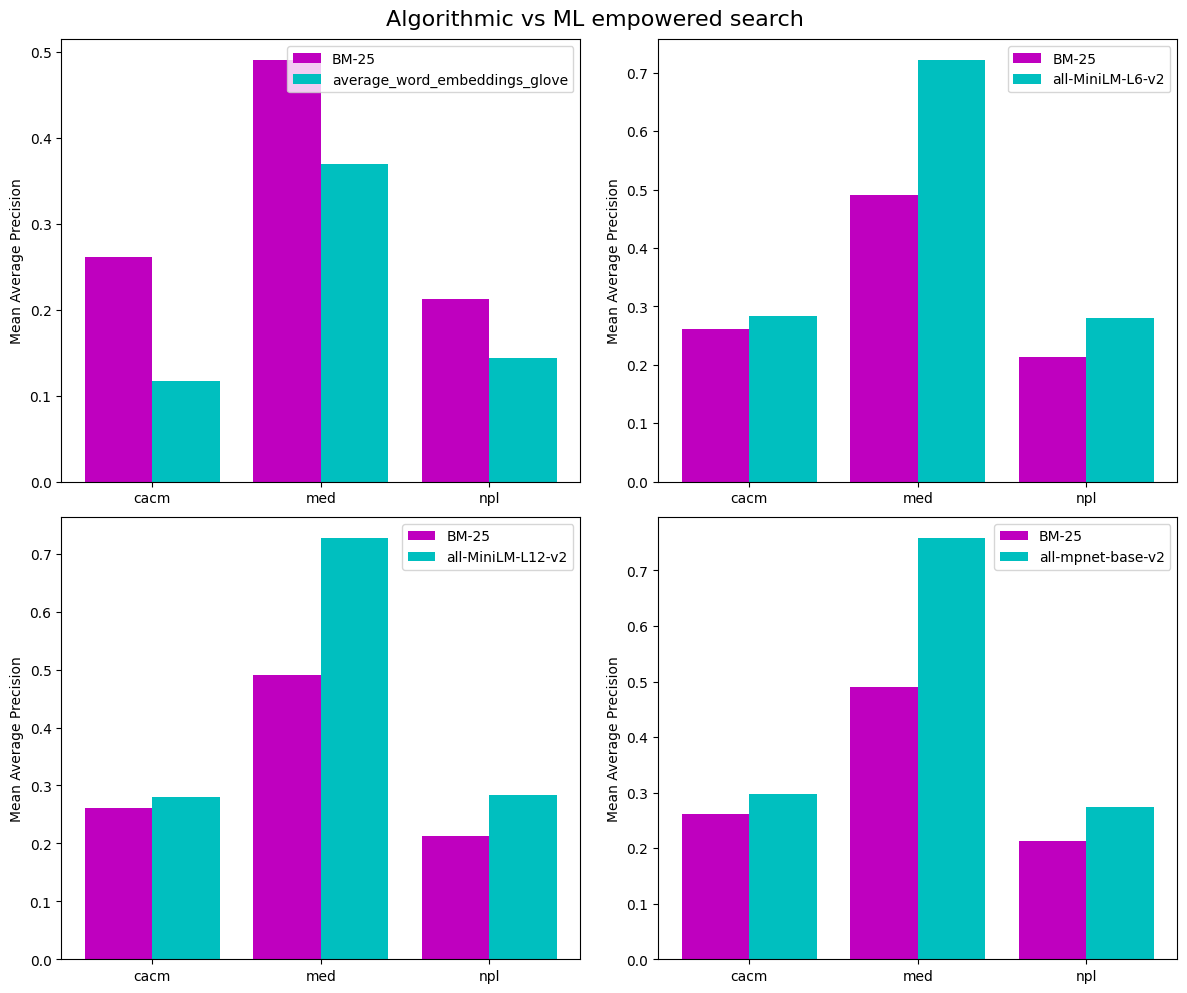

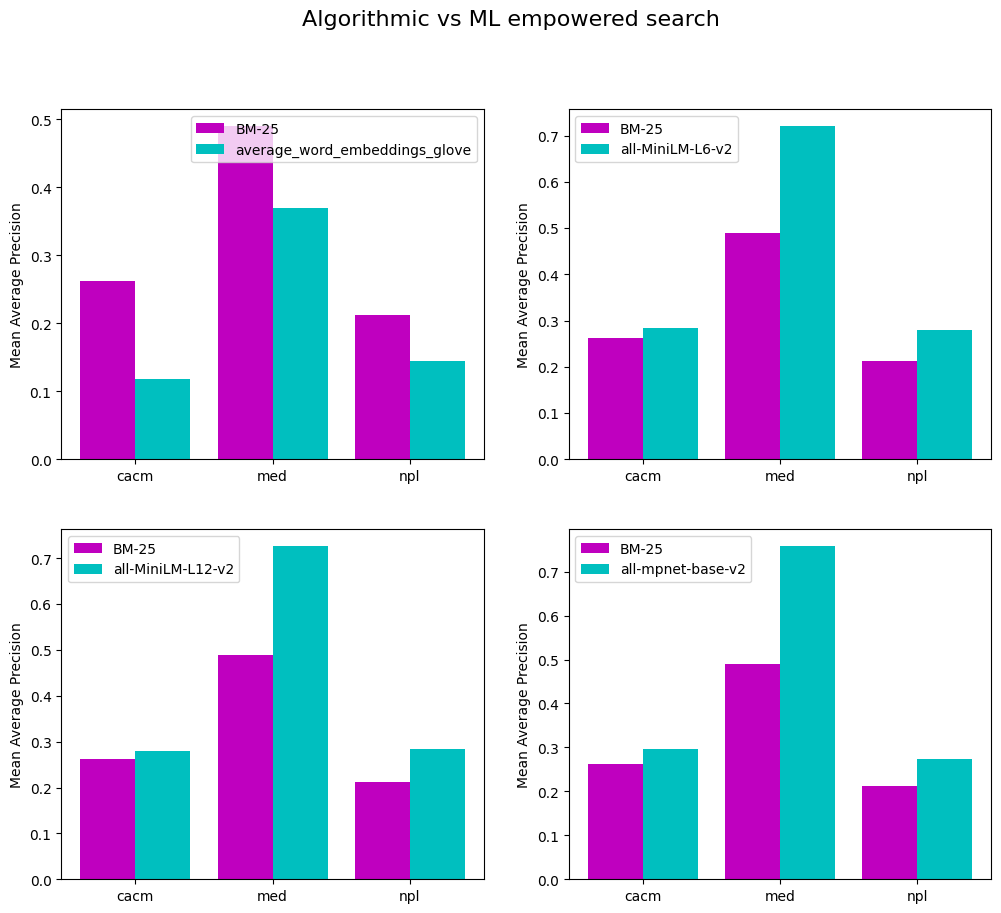

In [39]:
models = ["average_word_embeddings_glove.6B.300d", "all-MiniLM-L6-v2", "all-MiniLM-L12-v2", "all-mpnet-base-v2"]
shortcuts = ["glove", "minil6", "minil12", "mpnetv2"]

# glove vs BM-25
scatter_plot(["./task_01/results/map_%s_glove.txt", "./task_01/results/map_%s_bm25.txt"], 
                             ["average_word_embeddings_glove", "bm25"], "Algorithmic vs ML empowered search", "presentation/figures/glove_vs_bm25")

# minil6 vs BM-25
scatter_plot(["./task_01/results/map_%s_minil6.txt", "./task_01/results/map_%s_bm25.txt"], 
                             ["all-MiniLM-L6-v2", "bm25"], "Algorithmic vs ML empowered search", "presentation/figures/minil6_vs_bm25")

# minil12 vs BM-25
scatter_plot(["./task_01/results/map_%s_minil12.txt", "./task_01/results/map_%s_bm25.txt"], 
                             ["all-MiniLM-L12-v2", "bm25"], "Algorithmic vs ML empowered search", "presentation/figures/minil12_vs_bm25")

# mpnetv2 vs BM-25
scatter_plot(["./task_01/results/map_%s_mpnetv2.txt", "./task_01/results/map_%s_bm25.txt"], 
                             ["all-mpnet-base-v2", "bm25"], "Algorithmic vs ML empowered search", "presentation/figures/mpnetv2_vs_bm25")

# glove vs mpnetv2
scatter_plot(["./task_01/results/map_%s_mpnetv2.txt", "./task_01/results/map_%s_glove.txt"], 
                             ["all-mpnet-base-v2", "average_word_embeddings_glove"], "Algorithmic vs ML empowered search", "presentation/figures/glove_vs_mpnetv2")

bar_chart_plot_4_in_1(["./task_01/results/map_%s_bm25.txt"] * 4, 
                      ["./task_01/results/map_%s_glove.txt", "./task_01/results/map_%s_minil6.txt", "./task_01/results/map_%s_minil12.txt", 
                       "./task_01/results/map_%s_mpnetv2.txt"], 
                      [["BM-25", "average_word_embeddings_glove"], ["BM-25", "all-MiniLM-L6-v2"], ["BM-25", "all-MiniLM-L12-v2"], ["BM-25", "all-mpnet-base-v2"]],
                      "Algorithmic vs ML empowered search", "presentation/figures/task_01_bar_plot")

bar_chart_plot_nx_ny(["./task_01/results/map_%s_bm25.txt"] * 4, 
                      ["./task_01/results/map_%s_glove.txt", "./task_01/results/map_%s_minil6.txt", "./task_01/results/map_%s_minil12.txt", 
                       "./task_01/results/map_%s_mpnetv2.txt"], 
                      [["BM-25", "average_word_embeddings_glove"], ["BM-25", "all-MiniLM-L6-v2"], ["BM-25", "all-MiniLM-L12-v2"], ["BM-25", "all-mpnet-base-v2"]],
                      "Algorithmic vs ML empowered search", "presentation/figures/task_01_bar_plot")

## Task 02
In this task we use Google Pegasus to summarize the data and compare the results of the unsummarized and summarized using BM-25.

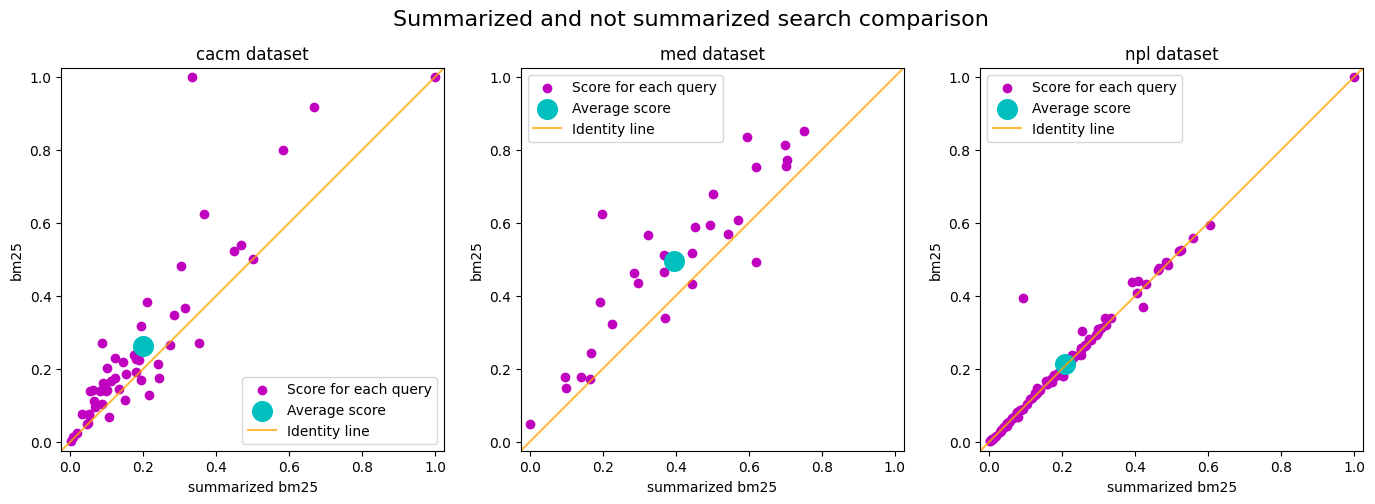

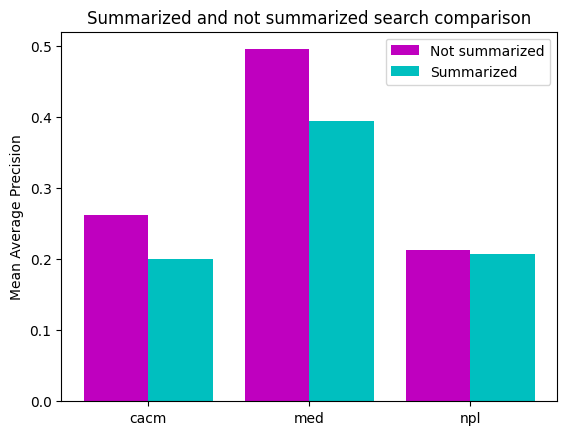

In [11]:
# not summarized vs fully summarized
scatter_plot(["./task_02/results/map_full_summarized_%s_bm25.txt", "./task_02/results/map_%s_bm25.txt"], 
                             ["full summarized bm25", "bm25"], "Fullly summarized and not summarized search comparison", "presentation/figures/full_summarized_bm25_vs_bm25")
bar_chart_plot("./task_02/results/map_%s_bm25.txt", "./task_02/results/map_full_summarized_%s_bm25.txt", ["Not summarized", "Summarized"],
               "Fully summarized and not summarized search comparison", "presentation/figures/fully_summarized_bm25_vs_bm25_bar")


# not summarized vs summarized
scatter_plot(["./task_02/results/map_partly_summarized_%s_bm25.txt", "./task_02/results/map_%s_bm25.txt"], 
                             ["partly summarized bm25", "bm25"], "Partly summarized and not summarized search comparison", "presentation/figures/partly_summarized_bm25_vs_bm25")
bar_chart_plot("./task_02/results/map_%s_bm25.txt", "./task_02/results/map_partly_summarized_%s_bm25.txt", ["Not summarized", "Summarized"],
               "Partly summarized and not summarized search comparison", "presentation/figures/partly_summarized_bm25_vs_bm25_bar")


## Task 03
TODO

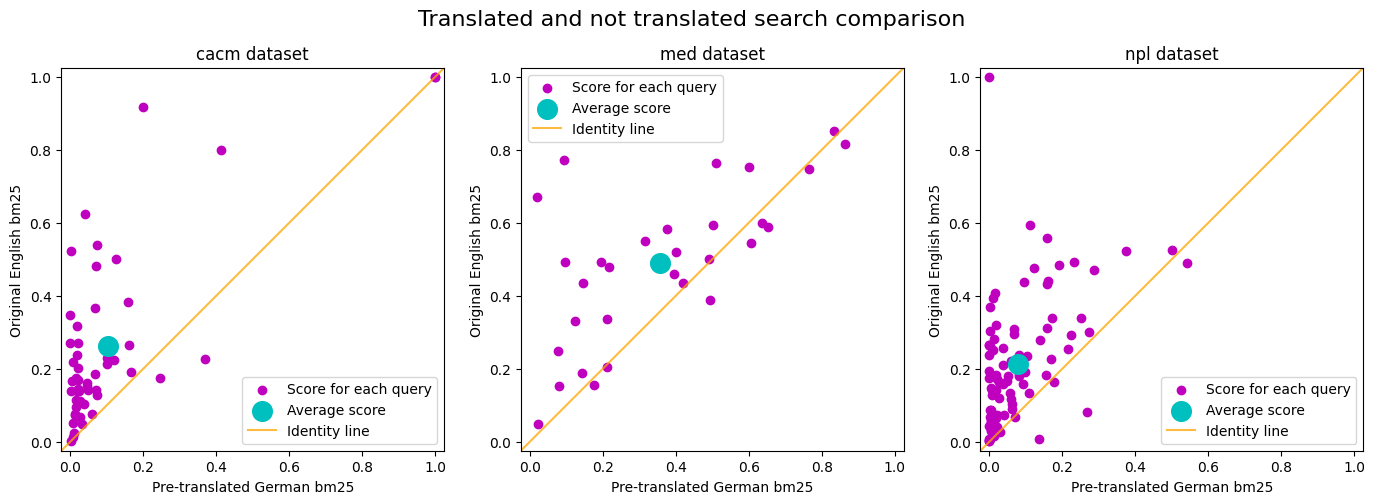

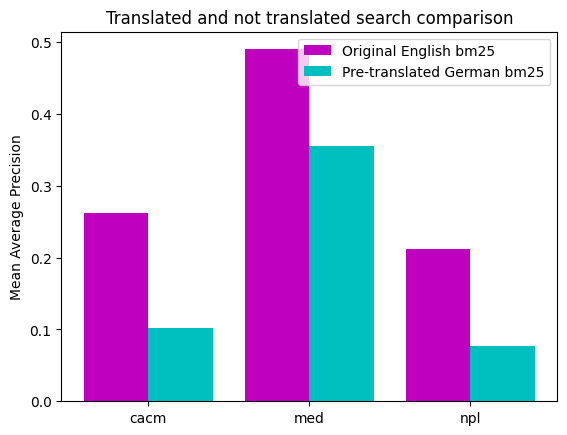

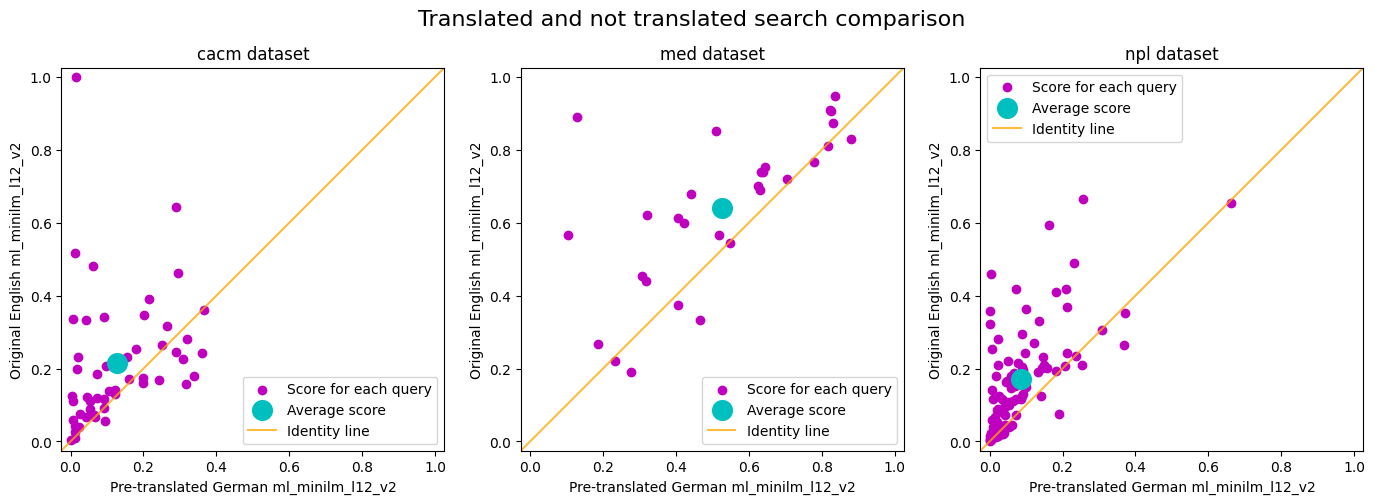

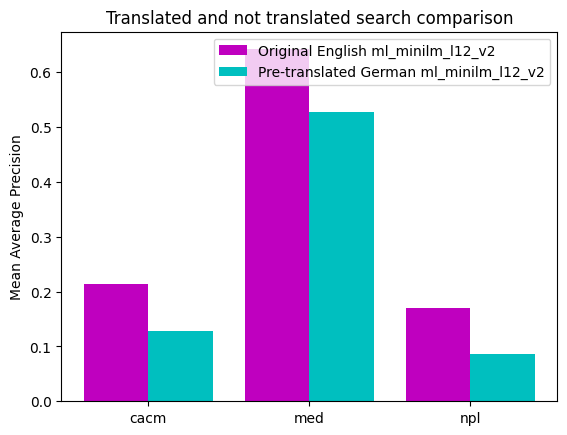

In [31]:
# translated vs not translated bm25
scatter_plot(["./task_03/results/map_ger_%s_bm25.txt", "./task_03/results/map_%s_bm25.txt"], 
                             ["Pre-translated German bm25", "Original English bm25"], "Translated and not translated search comparison", 
                             "presentation/figures/translated_not_translated_bm25")
bar_chart_plot("./task_03/results/map_%s_bm25.txt", "./task_03/results/map_ger_%s_bm25.txt", ["Original English bm25", "Pre-translated German bm25"],
               "Translated and not translated search comparison", "presentation/figures/translated_not_translated_bm25_bar")

# translated vs not translated ml_minilm_l12_v2
scatter_plot(["./task_03/results/map_ger_%s_ml_minilm_l12_v2.txt", "./task_03/results/map_%s_ml_minilm_l12_v2.txt"], 
                             ["Pre-translated German ml_minilm_l12_v2", "Original English ml_minilm_l12_v2"], "Translated and not translated search comparison", 
                             "presentation/figures/translated_not_translated_ml_minilm_l12_v2")
bar_chart_plot("./task_03/results/map_%s_ml_minilm_l12_v2.txt", "./task_03/results/map_ger_%s_ml_minilm_l12_v2.txt", ["Original English ml_minilm_l12_v2", "Pre-translated German ml_minilm_l12_v2"],
               "Translated and not translated search comparison", "presentation/figures/translated_not_translated_ml_minilm_l12_v2_bar")

## Task 04
In this task we fine-tuned pre-trained multilingual sentence transformers and evaluated their performance on queries in different languages.

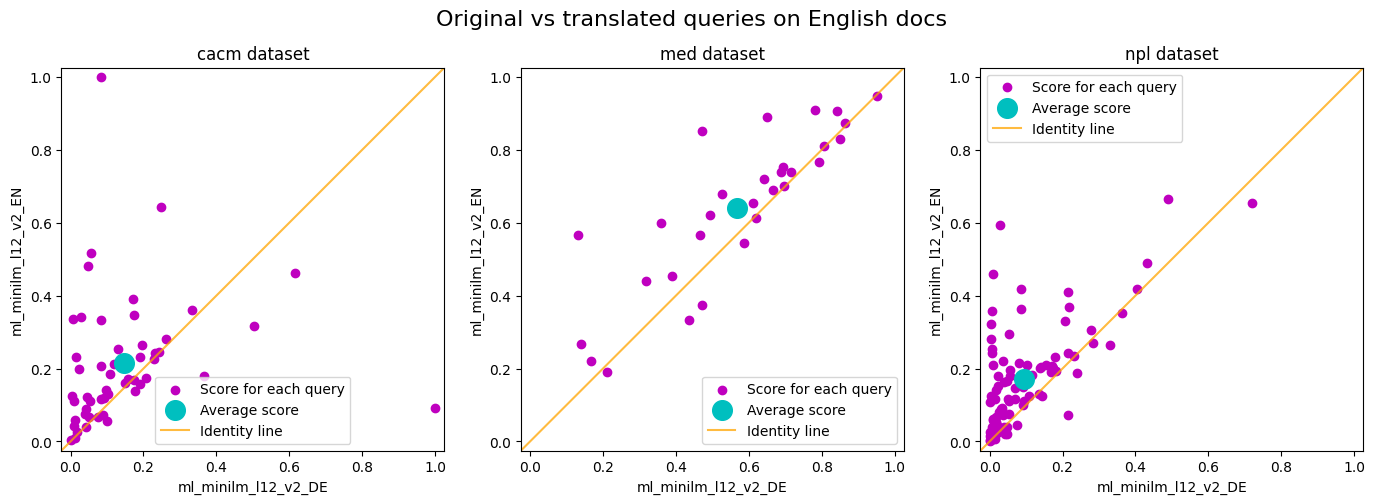

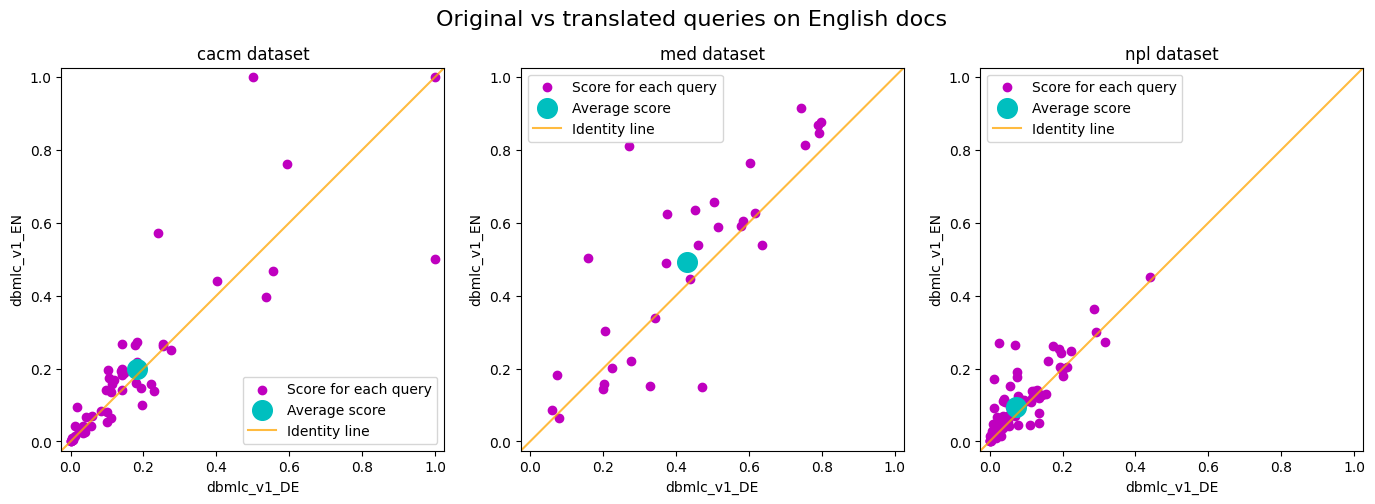

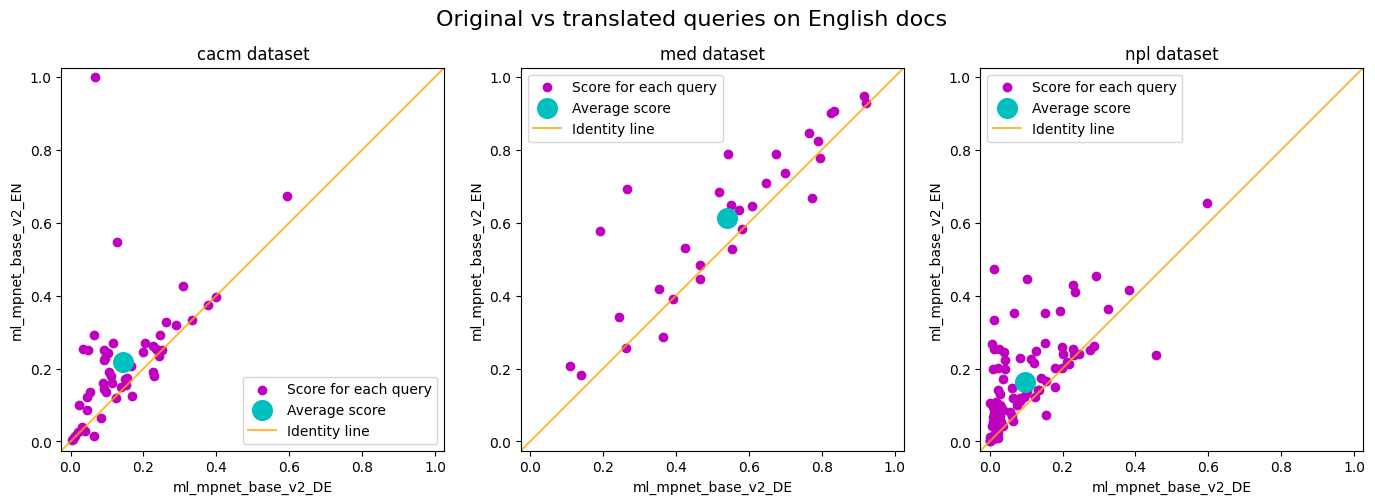

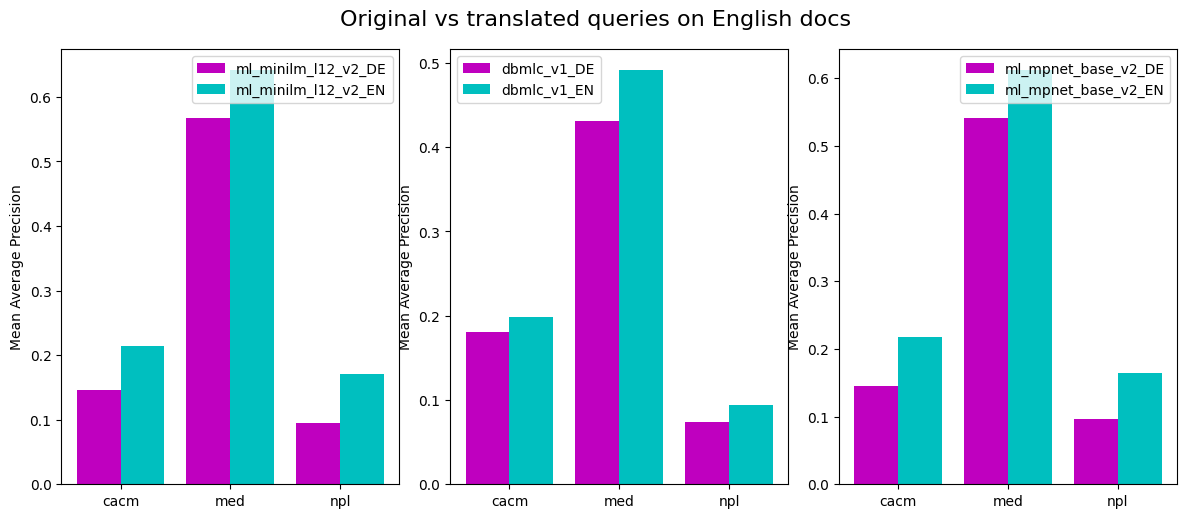

In [33]:
# sentence transformers models
models = ["paraphrase-multilingual-MiniLM-L12-v2", "distiluse-base-multilingual-cased-v1", "paraphrase-multilingual-mpnet-base-v2"]
shortcuts = ["ml_minilm_l12_v2", "dbmlc_v1", "ml_mpnet_base_v2"]

# compare performance of German queries vs English queries on English docs
for model_shortcut in shortcuts:
    scatter_plot([
        f"./task_04/results/map_ger_%s_{model_shortcut}.txt",
        f"./task_04/results/map_%s_{model_shortcut}.txt"
    ], [f"{model_shortcut}_DE", f"{model_shortcut}_EN"], "Original vs translated queries on English docs",
                 f"presentation/figures/DE_vs_EN_{model_shortcut}_on_EN")

#bar_chart_plot_4_in_1(f"./task_04/results/map_ger_%s_{model_shortcut}.txt", f"./task_04/results/map_%s_{model_shortcut}.txt",
#                ["German (translated)", "English (original)"], "Original vs translated documents and queries", "presentation/figures/DE_vs_EN_bar")


bar_chart_plot_nx_ny(["./task_04/results/map_ger_%s_ml_minilm_l12_v2.txt", "./task_04/results/map_ger_%s_dbmlc_v1.txt", "./task_04/results/map_ger_%s_ml_mpnet_base_v2.txt"], 
                     ["./task_04/results/map_%s_ml_minilm_l12_v2.txt", "./task_04/results/map_%s_dbmlc_v1.txt", "./task_04/results/map_%s_ml_mpnet_base_v2.txt"], 
                      [["ml_minilm_l12_v2_DE", "ml_minilm_l12_v2_EN"], ["dbmlc_v1_DE", "dbmlc_v1_EN"], ["ml_mpnet_base_v2_DE", "ml_mpnet_base_v2_EN"]],
                      "Original vs translated queries on English docs", "presentation/figures/task_04_bar_plot", 1, 3)